# *y-randomization* test

- We will use the `nk_rep_cross_validation_scrambling` function to perform *y-scrambling*.

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')

In [2]:
# Load some auxiliary functions
%run 1_Helper_functions.ipynb

/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
%load_ext rpy2.ipython

### Load docking results

In [4]:
prot_name = 'fxa'
file_name = '../4_Ensemble_docking_results/' + \
            'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X = df_dk_res.drop('activity', axis = 1).values
# Extract the response variable: Activity
y = df_dk_res['activity'].values

In [5]:
# Proportion of active molecules R_2
R_a = round(y.sum() / len(y), 4)

### Machine Learning Classifiers

In [6]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [7]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C'        : 0.01, 
            'penalty'  : 'l2', 
            'solver'   : 'lbfgs', 
            'max_iter' :400}
lr = LogisticRegression(**hyparams)

In [8]:
from xgboost import XGBClassifier

hyparams = {'subsample'       : 0.5, 
            'n_estimators'    : 200, 
            'max_depth'       : 10, 
            'learning_rate'   : 0.1,
            'alpha'           : 0.5,
            'gamma'           : 1, 
            'colsample_bytree': 1}

xgb = XGBClassifier(**hyparams)

In [9]:
# ML Classifiers
ml_classifiers = {
    'ml_lr'  : lr,
    'ml_xgb' : xgb,
    'ml_dclf': dclf
}

### Consensus Strategies

In [10]:
from helper_modules.consensus_strategies import \
    get_mean_score, get_min_score, get_geom_mean_score

In [11]:
cs_functions = {
    'cs_MEAN': get_mean_score,
    'cs_GEOM': get_geom_mean_score,
    'cs_MIN' : get_min_score
}

### SBVS methods (estimators) dictionary

In [12]:
estimators = {**ml_classifiers, **cs_functions}

# Map new names for each VS method, for plotting
full_names = ['LR', 'GBT', 'DClf', 
              'csAVG', 'csGEO', 'csMIN']
sbvs_names = dict(zip(
    estimators.keys(),
    full_names))
sbvs_names

{'ml_lr': 'LR',
 'ml_xgb': 'GBT',
 'ml_dclf': 'DClf',
 'cs_MEAN': 'csAVG',
 'cs_GEOM': 'csGEO',
 'cs_MIN': 'csMIN'}

### Evaluation metrics

In [13]:
metrics = dict(
    # AUC-ROC
    roc_auc   = {'metric_name': 'roc_auc'},
    # Normalized Enrichment Factor
    nef_05_Ra = {'metric_name': 'ef', 
                 'fraction'   : R_a, 
                 'method'     : 'normalized'}
    )

## *y-randomization* test

In [14]:
# Define an output directory to save the results
OUT_DIR = './cachedir/y_scrambling'

In [15]:
# Perform a 30x4-fold CV at each chi fraction
n_repeats = 30 # n
n_splits = 4   # k

# Set of chi fractions
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
# Dictionary of results
chi_results = {}
evaluation_name = f'y_scrambling_reps_{n_repeats}x{n_splits}CV'

for chi in chi_fractions:
    # filename to save the results as a python object
    filename = f'{OUT_DIR}/{evaluation_name}_{prot_name}_chi-{chi}'
    # Perform the y-randomization test
    result = nk_rep_cross_validation_scrambling(
                         filename   = filename, 
                         X = X, 
                         y = y,
                         random_chi = chi, 
                         estimators = estimators, 
                         metrics    = metrics, 
                         n_repeats  = n_repeats, 
                         n_splits   = n_splits)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result

File loaded: ./cachedir/y_scrambling/y_scrambling_reps_30x4CV_fxa_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling/y_scrambling_reps_30x4CV_fxa_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling/y_scrambling_reps_30x4CV_fxa_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling/y_scrambling_reps_30x4CV_fxa_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling/y_scrambling_reps_30x4CV_fxa_chi-0.0
Fraction chi=0.0 finished.


## AUC-ROC Results

In [16]:
# Define a simple function to return a dataframe
# from the y_scrambling results
def get_y_rand_results(metric):
    df = get_group_stats(chi_results, 
                         metric_name = metric)
    df = df.replace(sbvs_names)
    df = df[df['method'].isin(full_names)]
    return df

In [17]:
# Get the dataframe
df_y_random = get_y_rand_results(metric = 'roc_auc')
df_y_random.head()

,index,method,mean,std
0,100,LR,0.498602,0.032902
1,75,LR,0.542282,0.035920
2,50,LR,0.626459,0.032806
3,25,LR,0.732343,0.034126
4,0,LR,0.833314,0.020369


R[write to console]: Registering fonts with R

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: The following object is masked from ‘package:plyr’:

    count


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

R[write to console]: ── Co

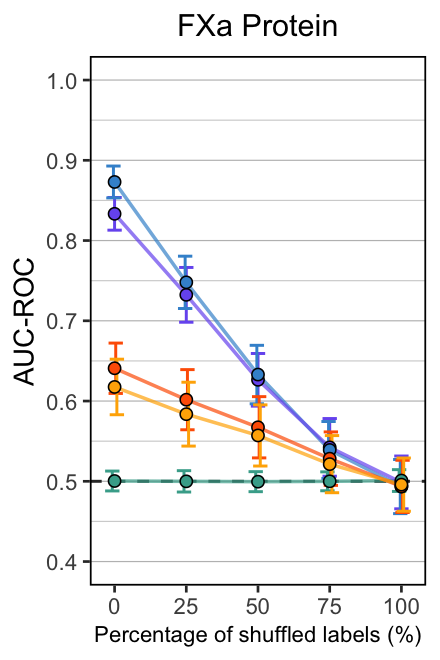

In [18]:
%%R -i df_y_random -w 2.2 -h 3.3 --units in -r 200
# Load the source file
source('../../R_scripts/plot_violinBox.R')
# Plot the AUC-ROC results
p = plot_lines(df_y_random, 
               cbbPalette  = cbbPalette, 
               point_size  = 1.8, 
               line_size   = 0.6, 
               switch_x    = FALSE,
               error_size  = 0.5, 
               error_dodge = 2, 
               color_column='method',
               error_width = 25) +
ggtitle('FXa Protein')
# Show the plot
p

### Normalized EF

In [19]:
# Get the dataframe
df_y_random = get_y_rand_results(metric = 'nef_05_Ra')
df_y_random.head()

,index,method,mean,std
0,100,LR,0.045556,0.022905
1,75,LR,0.074111,0.029628
2,50,LR,0.161667,0.036116
3,25,LR,0.278889,0.041181
4,0,LR,0.404778,0.049158


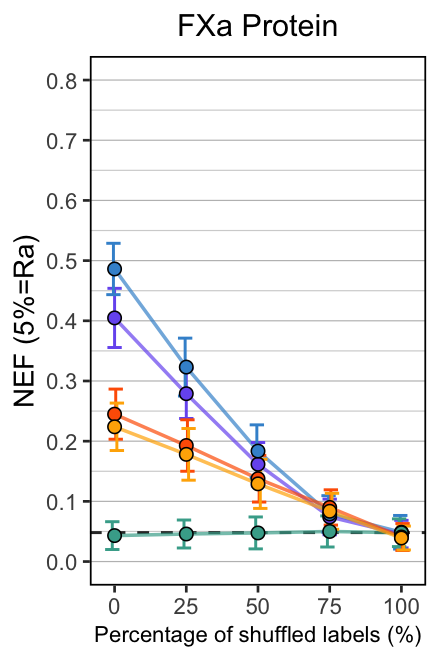

In [20]:
%%R -i df_y_random -i R_a -w 2.2 -h 3.3 --units in -r 200
# Load the source file
source('../../R_scripts/plot_violinBox.R')
# Plot the AUC-ROC results
p = plot_lines(df_y_random, 
               cbbPalette, 
               point_size  = 2., 
               line_size   = 0.6,
               error_size  = 0.5, 
               error_dodge = 2, 
               error_width = 25, 
               switch_x    = FALSE,
               y_min       = 0, 
               y_max       = 0.8, 
               base_h_line = R_a, 
               color_column='method',
               y_label     = 'NEF (5%=Ra)') +
ggtitle('FXa Protein')
# Show the plot
p

Finished!